# Dataset Preprocessing and Previsualization

The first step of this project is to get an initial overview of the dataset we're utilizing includding information such as number of samples, feature datatypes, and missing values.

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

!pip install copulas

df = pd.read_csv('/content/drive/MyDrive/2024 Spring/CPSC 499/Project/adult.csv')
print(df.info(verbose=True))
print('------------')
print(df.head())

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.4 MB/s eta 0:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory us

It's important to note missing values in this data set are represented utilizing '?' instead of NaN. To fill these missing values we will label encode non-missing values and then impute the means of features into the missing entries. Once all of our features are numeric we can then utilize min-max scaling to improve the performance of our models. Note that when evaluating Generator performance we will need to have a real category appended to our non-synthetic data, however, we cannot add this before utilizing the generator.

In [2]:
from sklearn.preprocessing import LabelEncoder

# Replacing '?' entries with NA for fillna functionality
# df.replace('?', pd.NA, inplace=True)

le = LabelEncoder()
for col in df.columns:
  # Feature encoding
  df[col] = le.fit_transform(df[col])
  # Feature imputing
  df.fillna({col: df[col].mean()}, inplace=True)
  # Feature scaling, DO NOT SCALE TARGET
  if col != 'income':
    colMax = df[col].max()
    colMin = df[col].min()
    df[col] = (df[col] - colMin)/(colMax - colMin)

print(df.info(verbose=True))
print('------------')
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  float64
 1   workclass       32561 non-null  float64
 2   fnlwgt          32561 non-null  float64
 3   education       32561 non-null  float64
 4   education.num   32561 non-null  float64
 5   marital.status  32561 non-null  float64
 6   occupation      32561 non-null  float64
 7   relationship    32561 non-null  float64
 8   race            32561 non-null  float64
 9   sex             32561 non-null  float64
 10  capital.gain    32561 non-null  float64
 11  capital.loss    32561 non-null  float64
 12  hours.per.week  32561 non-null  float64
 13  native.country  32561 non-null  float64
 14  income          32561 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 3.7 MB
None
------------
        age  workclass    fnlwgt  education  education.nu

Now that we've preprocessed our DataFrame we can visualize the it to gain a better understanding about the features as well as how they correlate to our target.

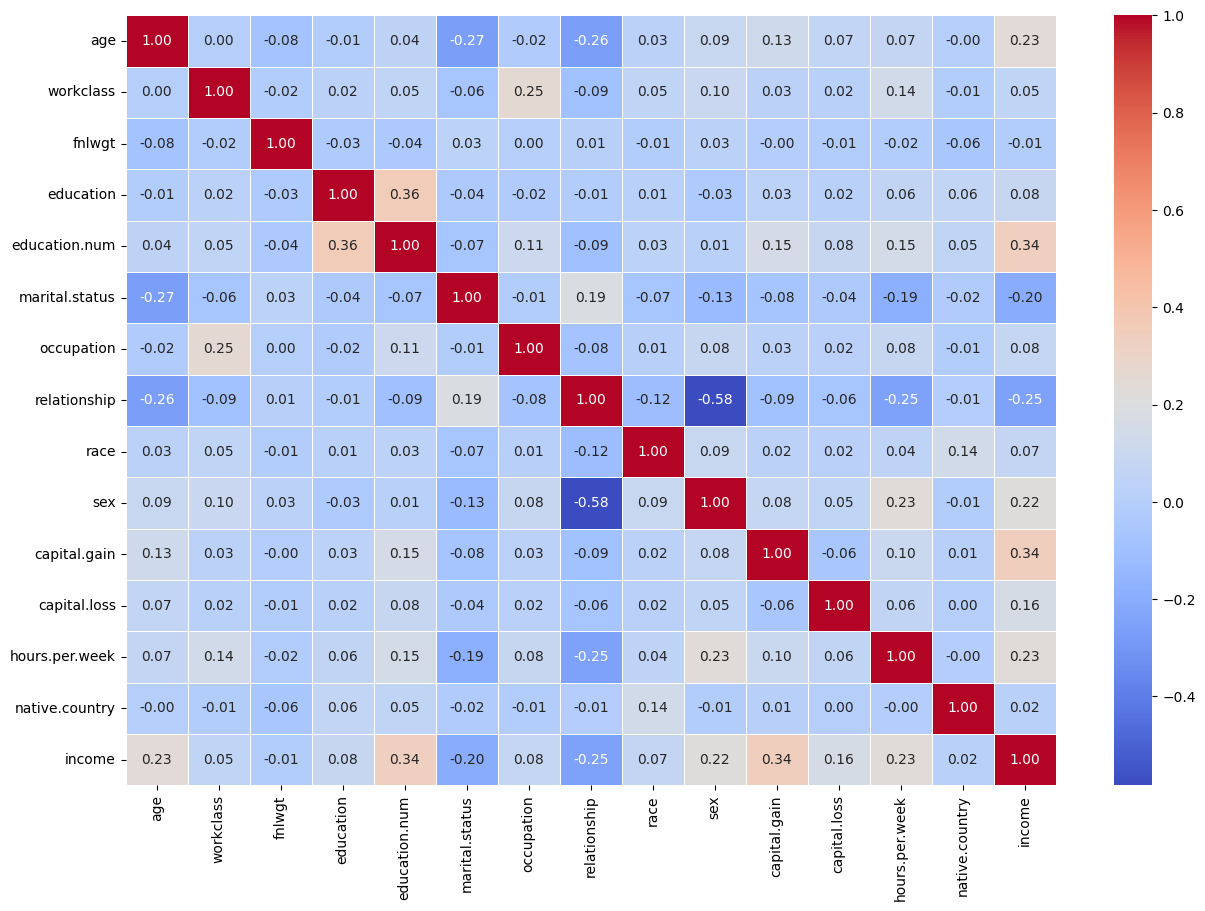

age mean: 0.2997267521813758
workclass mean: 0.4836115291299407
fnlwgt mean: 0.485004503105845
education mean: 0.6865473009633201
education.num mean: 0.6053786226876733
marital.status mean: 0.4353060409692577
occupation mean: 0.46948145678221537
relationship mean: 0.28927244249255246
race mean: 0.9164644820490772
sex mean: 0.6692054912318418
capital.gain mean: 0.0550950263364876
capital.loss mean: 0.022563567080013135
hours.per.week mean: 0.4234186752209995
native.country mean: 0.8955821006875649
income mean: 0.2408095574460244


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

# Feature Means
for col in df.columns:
  print(f"{col} mean: {df[col].mean()}")

The final step of preprocessing data is to transfer our pandas DataFrame into a TensorFlow dataset for ease of use in our model.

In [4]:
import tensorflow as tf

BATCH_SIZE = 500

data_array = df.values
data_tensor = tf.constant(data_array, dtype=tf.float32)


# Converting to TF DataSet and batching for future model training
dataset = tf.data.Dataset.from_tensor_slices(data_tensor).batch(BATCH_SIZE)

# Generator and Discriminator Construction

Now that we've done initial data analysis and preprocessing we can move into constructing our GAN; including both the Generator and Discriminator. First we will construct the Discriminator which includes defining it's layer construction as well as manually defining it's loss function for use in our GAN.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import tensorflow as tf

cross_entropy = tf.keras.losses.BinaryCrossentropy()

discriminator = Sequential(
    [
      # Input Layer
      Dense(units=50, activation='LeakyReLU', input_shape=(15,)),
      # Hidden Layer(s)
      Dense(units=50, activation='LeakyReLU'),
      Dense(units=75, activation='LeakyReLU'),
      Dense(units=75, activation='LeakyReLU'),
      Dense(units=50, activation='LeakyReLU'),
      # Output Layer
      Dense(units=1, activation='sigmoid')
    ],
    name='discriminator'
)

def discriminator_loss(real_output, fake_output):
  # Calculates the total loss of our discriminator (Reals are compared to ones, fakes are compared to zeros)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = (real_loss + fake_loss)/2
  return total_loss

disc_optimizer = tf.keras.optimizers.Adam(1.45e-4)


Now we create the Generator which once again consists of defining layer structure as well as giving a standalone definition of it's loss function for explicit use in our GAN.

In [6]:
noise_dim = 100

generator = Sequential(
    [
      # Input Layer
      Dense(units=50, activation='LeakyReLU', input_dim=noise_dim),
      # Hidden Layer(s)
      Dense(units=50, activation='LeakyReLU'),
      Dense(units=75, activation='LeakyReLU'),
      Dense(units=75, activation='LeakyReLU'),
      Dense(units=50, activation='LeakyReLU'),
      # Output Layer
      Dense(units=15, activation='sigmoid')
    ],
    name='generator'
)

def generator_loss(fake_output):
  # Calculates how well the generator tricked the discriminator (Thus ones_like on fake)
  return cross_entropy(tf.ones_like(fake_output), fake_output)

gen_optimizer = tf.keras.optimizers.Adam(1e-4)


# GAN Construction

Now that we've created our Generator and Discriminator we need to interlink them and create our GAN. The first step of creating our GAN is to explicitly define the unique training structure of our GAN including our previous loss functions as well as gradient calculations.

In [7]:
from tqdm import tqdm


epochs = 100

gen_losses = []
disc_losses = []

# Iterating through each batch of our dataset
for epoch in range(epochs):
  print('-----------')
  print('')
  print(f"Epoch {epoch+1}/{epochs}")
  print('')
  print('-----------')
  progress_bar = tqdm(dataset, unit="batches")
  epoch_gen_loss = tf.keras.metrics.Mean()
  epoch_disc_loss = tf.keras.metrics.Mean()
  for data_batch in progress_bar:

    # Creating random noise for generator input
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generating synthetic data
      generated_data = generator(noise, training=True)
      # Rounding income bracket to 1 or 0
      income = generated_data[:, -1]
      rounded_income = tf.round(income)
      rounded_data = tf.concat([generated_data[:, :-1], tf.expand_dims(rounded_income, axis=1)], axis=1)

      # Getting the output of our discriminator where real and synthetic data are given seperately
      real_output = discriminator(data_batch, training=True)
      fake_output = discriminator(rounded_data, training=False)

      # Finding the loss of our generator and discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      epoch_gen_loss.update_state(gen_loss)
      epoch_disc_loss.update_state(disc_loss)

      # Finding the gradient of our generator and discriminator's loss function
      gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
      disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Optimizing and updating the gradients of our models
      gen_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
      disc_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))

      # Compute the cumulative average loss for generator and discriminator
      cumulative_avg_gen_loss = epoch_gen_loss.result().numpy()
      cumulative_avg_disc_loss = epoch_disc_loss.result().numpy()

      progress_bar.set_description(f"Avg Gen Loss: {cumulative_avg_gen_loss:.4f}, Avg Disc Loss: {cumulative_avg_disc_loss:.4f}")

  # Saving all model losses for future visualization
  gen_losses.append(cumulative_avg_gen_loss)
  disc_losses.append(cumulative_avg_disc_loss)



-----------

Epoch 1/100

-----------


Avg Gen Loss: 0.7625, Avg Disc Loss: 0.6234: 100%|██████████| 66/66 [00:23<00:00,  2.80batches/s]


-----------

Epoch 2/100

-----------


Avg Gen Loss: 0.8408, Avg Disc Loss: 0.5667: 100%|██████████| 66/66 [00:20<00:00,  3.22batches/s]


-----------

Epoch 3/100

-----------


Avg Gen Loss: 0.8116, Avg Disc Loss: 0.7096: 100%|██████████| 66/66 [00:09<00:00,  6.77batches/s]


-----------

Epoch 4/100

-----------


Avg Gen Loss: 0.7786, Avg Disc Loss: 0.5479: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 5/100

-----------


Avg Gen Loss: 0.9886, Avg Disc Loss: 0.4505: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 6/100

-----------


Avg Gen Loss: 1.0382, Avg Disc Loss: 0.5964: 100%|██████████| 66/66 [00:09<00:00,  7.00batches/s]


-----------

Epoch 7/100

-----------


Avg Gen Loss: 1.2908, Avg Disc Loss: 0.4199: 100%|██████████| 66/66 [00:09<00:00,  6.94batches/s]


-----------

Epoch 8/100

-----------


Avg Gen Loss: 1.8153, Avg Disc Loss: 0.2189: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 9/100

-----------


Avg Gen Loss: 1.7361, Avg Disc Loss: 0.4230: 100%|██████████| 66/66 [00:08<00:00,  7.63batches/s]


-----------

Epoch 10/100

-----------


Avg Gen Loss: 1.3146, Avg Disc Loss: 0.4281: 100%|██████████| 66/66 [00:10<00:00,  6.19batches/s]


-----------

Epoch 11/100

-----------


Avg Gen Loss: 1.0065, Avg Disc Loss: 0.5740: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 12/100

-----------


Avg Gen Loss: 1.4147, Avg Disc Loss: 0.4491: 100%|██████████| 66/66 [00:08<00:00,  7.44batches/s]


-----------

Epoch 13/100

-----------


Avg Gen Loss: 1.0637, Avg Disc Loss: 0.6413: 100%|██████████| 66/66 [00:09<00:00,  7.11batches/s]


-----------

Epoch 14/100

-----------


Avg Gen Loss: 1.6720, Avg Disc Loss: 0.3449: 100%|██████████| 66/66 [00:09<00:00,  6.82batches/s]


-----------

Epoch 15/100

-----------


Avg Gen Loss: 1.2747, Avg Disc Loss: 0.5417: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 16/100

-----------


Avg Gen Loss: 1.1144, Avg Disc Loss: 0.5258: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 17/100

-----------


Avg Gen Loss: 1.5789, Avg Disc Loss: 0.3004: 100%|██████████| 66/66 [00:09<00:00,  7.00batches/s]


-----------

Epoch 18/100

-----------


Avg Gen Loss: 2.2755, Avg Disc Loss: 0.1689: 100%|██████████| 66/66 [00:09<00:00,  6.82batches/s]


-----------

Epoch 19/100

-----------


Avg Gen Loss: 1.8819, Avg Disc Loss: 0.3882: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 20/100

-----------


Avg Gen Loss: 1.6429, Avg Disc Loss: 0.4566: 100%|██████████| 66/66 [00:08<00:00,  7.76batches/s]


-----------

Epoch 21/100

-----------


Avg Gen Loss: 1.7426, Avg Disc Loss: 0.3625: 100%|██████████| 66/66 [00:10<00:00,  6.23batches/s]


-----------

Epoch 22/100

-----------


Avg Gen Loss: 1.6413, Avg Disc Loss: 0.3661: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 23/100

-----------


Avg Gen Loss: 1.4373, Avg Disc Loss: 0.4505: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 24/100

-----------


Avg Gen Loss: 1.6431, Avg Disc Loss: 0.3497: 100%|██████████| 66/66 [00:08<00:00,  7.54batches/s]


-----------

Epoch 25/100

-----------


Avg Gen Loss: 1.8537, Avg Disc Loss: 0.3299: 100%|██████████| 66/66 [00:11<00:00,  5.99batches/s]


-----------

Epoch 26/100

-----------


Avg Gen Loss: 1.9654, Avg Disc Loss: 0.2507: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 27/100

-----------


Avg Gen Loss: 1.9982, Avg Disc Loss: 0.3062: 100%|██████████| 66/66 [00:09<00:00,  7.26batches/s]


-----------

Epoch 28/100

-----------


Avg Gen Loss: 1.7016, Avg Disc Loss: 0.3902: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 29/100

-----------


Avg Gen Loss: 1.8392, Avg Disc Loss: 0.2553: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 30/100

-----------


Avg Gen Loss: 1.8955, Avg Disc Loss: 0.2645: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 31/100

-----------


Avg Gen Loss: 1.8329, Avg Disc Loss: 0.3329: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 32/100

-----------


Avg Gen Loss: 1.7762, Avg Disc Loss: 0.3310: 100%|██████████| 66/66 [00:08<00:00,  7.34batches/s]


-----------

Epoch 33/100

-----------


Avg Gen Loss: 2.1298, Avg Disc Loss: 0.2370: 100%|██████████| 66/66 [00:09<00:00,  6.82batches/s]


-----------

Epoch 34/100

-----------


Avg Gen Loss: 2.1290, Avg Disc Loss: 0.3714: 100%|██████████| 66/66 [00:09<00:00,  6.72batches/s]


-----------

Epoch 35/100

-----------


Avg Gen Loss: 1.8959, Avg Disc Loss: 0.3706: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 36/100

-----------


Avg Gen Loss: 1.9858, Avg Disc Loss: 0.3292: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 37/100

-----------


Avg Gen Loss: 2.0187, Avg Disc Loss: 0.3594: 100%|██████████| 66/66 [00:09<00:00,  6.73batches/s]


-----------

Epoch 38/100

-----------


Avg Gen Loss: 1.9271, Avg Disc Loss: 0.3700: 100%|██████████| 66/66 [00:09<00:00,  6.70batches/s]


-----------

Epoch 39/100

-----------


Avg Gen Loss: 1.9896, Avg Disc Loss: 0.2800: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 40/100

-----------


Avg Gen Loss: 2.0529, Avg Disc Loss: 0.3008: 100%|██████████| 66/66 [00:09<00:00,  7.02batches/s]


-----------

Epoch 41/100

-----------


Avg Gen Loss: 1.8760, Avg Disc Loss: 0.4369: 100%|██████████| 66/66 [00:09<00:00,  6.71batches/s]


-----------

Epoch 42/100

-----------


Avg Gen Loss: 1.5977, Avg Disc Loss: 0.3615: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 43/100

-----------


Avg Gen Loss: 1.5715, Avg Disc Loss: 0.3452: 100%|██████████| 66/66 [00:08<00:00,  7.65batches/s]


-----------

Epoch 44/100

-----------


Avg Gen Loss: 1.8242, Avg Disc Loss: 0.2704: 100%|██████████| 66/66 [00:09<00:00,  6.75batches/s]


-----------

Epoch 45/100

-----------


Avg Gen Loss: 1.7184, Avg Disc Loss: 0.3494: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 46/100

-----------


Avg Gen Loss: 1.6458, Avg Disc Loss: 0.4124: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 47/100

-----------


Avg Gen Loss: 1.9161, Avg Disc Loss: 0.4110: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 48/100

-----------


Avg Gen Loss: 1.8495, Avg Disc Loss: 0.3836: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 49/100

-----------


Avg Gen Loss: 2.0865, Avg Disc Loss: 0.3220: 100%|██████████| 66/66 [00:09<00:00,  6.66batches/s]


-----------

Epoch 50/100

-----------


Avg Gen Loss: 1.7186, Avg Disc Loss: 0.3664: 100%|██████████| 66/66 [00:09<00:00,  7.06batches/s]


-----------

Epoch 51/100

-----------


Avg Gen Loss: 1.6442, Avg Disc Loss: 0.4090: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 52/100

-----------


Avg Gen Loss: 1.5136, Avg Disc Loss: 0.3936: 100%|██████████| 66/66 [00:09<00:00,  6.68batches/s]


-----------

Epoch 53/100

-----------


Avg Gen Loss: 1.5339, Avg Disc Loss: 0.3942: 100%|██████████| 66/66 [00:10<00:00,  6.26batches/s]


-----------

Epoch 54/100

-----------


Avg Gen Loss: 1.5941, Avg Disc Loss: 0.4355: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 55/100

-----------


Avg Gen Loss: 1.9572, Avg Disc Loss: 0.3466: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 56/100

-----------


Avg Gen Loss: 1.9807, Avg Disc Loss: 0.2717: 100%|██████████| 66/66 [00:10<00:00,  6.02batches/s]


-----------

Epoch 57/100

-----------


Avg Gen Loss: 2.0334, Avg Disc Loss: 0.2988: 100%|██████████| 66/66 [00:20<00:00,  3.22batches/s]


-----------

Epoch 58/100

-----------


Avg Gen Loss: 1.7382, Avg Disc Loss: 0.3661: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 59/100

-----------


Avg Gen Loss: 1.8111, Avg Disc Loss: 0.3469: 100%|██████████| 66/66 [00:09<00:00,  7.24batches/s]


-----------

Epoch 60/100

-----------


Avg Gen Loss: 1.8917, Avg Disc Loss: 0.2986: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 61/100

-----------


Avg Gen Loss: 1.8494, Avg Disc Loss: 0.3082: 100%|██████████| 66/66 [00:09<00:00,  6.71batches/s]


-----------

Epoch 62/100

-----------


Avg Gen Loss: 1.8331, Avg Disc Loss: 0.3073: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 63/100

-----------


Avg Gen Loss: 1.8757, Avg Disc Loss: 0.3014: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 64/100

-----------


Avg Gen Loss: 1.7471, Avg Disc Loss: 0.3708: 100%|██████████| 66/66 [00:09<00:00,  6.63batches/s]


-----------

Epoch 65/100

-----------


Avg Gen Loss: 1.5141, Avg Disc Loss: 0.3968: 100%|██████████| 66/66 [00:09<00:00,  6.73batches/s]


-----------

Epoch 66/100

-----------


Avg Gen Loss: 1.4849, Avg Disc Loss: 0.3433: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 67/100

-----------


Avg Gen Loss: 1.5838, Avg Disc Loss: 0.3629: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 68/100

-----------


Avg Gen Loss: 1.6279, Avg Disc Loss: 0.3861: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 69/100

-----------


Avg Gen Loss: 1.7391, Avg Disc Loss: 0.3659: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 70/100

-----------


Avg Gen Loss: 1.5415, Avg Disc Loss: 0.3875: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 71/100

-----------


Avg Gen Loss: 1.5803, Avg Disc Loss: 0.3769: 100%|██████████| 66/66 [00:08<00:00,  7.49batches/s]


-----------

Epoch 72/100

-----------


Avg Gen Loss: 1.5425, Avg Disc Loss: 0.4515: 100%|██████████| 66/66 [00:09<00:00,  6.68batches/s]


-----------

Epoch 73/100

-----------


Avg Gen Loss: 1.6296, Avg Disc Loss: 0.3997: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 74/100

-----------


Avg Gen Loss: 1.6173, Avg Disc Loss: 0.3687: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 75/100

-----------


Avg Gen Loss: 1.7107, Avg Disc Loss: 0.2883: 100%|██████████| 66/66 [00:09<00:00,  7.29batches/s]


-----------

Epoch 76/100

-----------


Avg Gen Loss: 1.7969, Avg Disc Loss: 0.3650: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 77/100

-----------


Avg Gen Loss: 1.5621, Avg Disc Loss: 0.4640: 100%|██████████| 66/66 [00:09<00:00,  6.69batches/s]


-----------

Epoch 78/100

-----------


Avg Gen Loss: 1.5671, Avg Disc Loss: 0.4105: 100%|██████████| 66/66 [00:08<00:00,  7.59batches/s]


-----------

Epoch 79/100

-----------


Avg Gen Loss: 1.5013, Avg Disc Loss: 0.3814: 100%|██████████| 66/66 [00:09<00:00,  6.74batches/s]


-----------

Epoch 80/100

-----------


Avg Gen Loss: 1.5841, Avg Disc Loss: 0.3270: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 81/100

-----------


Avg Gen Loss: 1.4798, Avg Disc Loss: 0.3923: 100%|██████████| 66/66 [00:09<00:00,  6.96batches/s]


-----------

Epoch 82/100

-----------


Avg Gen Loss: 1.8321, Avg Disc Loss: 0.3991: 100%|██████████| 66/66 [00:09<00:00,  7.22batches/s]


-----------

Epoch 83/100

-----------


Avg Gen Loss: 1.4292, Avg Disc Loss: 0.5670: 100%|██████████| 66/66 [00:09<00:00,  6.71batches/s]


-----------

Epoch 84/100

-----------


Avg Gen Loss: 1.2726, Avg Disc Loss: 0.4653: 100%|██████████| 66/66 [00:09<00:00,  6.67batches/s]


-----------

Epoch 85/100

-----------


Avg Gen Loss: 1.3193, Avg Disc Loss: 0.4481: 100%|██████████| 66/66 [00:08<00:00,  7.56batches/s]


-----------

Epoch 86/100

-----------


Avg Gen Loss: 1.4116, Avg Disc Loss: 0.4222: 100%|██████████| 66/66 [00:09<00:00,  6.64batches/s]


-----------

Epoch 87/100

-----------


Avg Gen Loss: 1.5461, Avg Disc Loss: 0.3613: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 88/100

-----------


Avg Gen Loss: 1.5197, Avg Disc Loss: 0.3976: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 89/100

-----------


Avg Gen Loss: 1.5095, Avg Disc Loss: 0.3597: 100%|██████████| 66/66 [00:08<00:00,  7.47batches/s]


-----------

Epoch 90/100

-----------


Avg Gen Loss: 1.5830, Avg Disc Loss: 0.3667: 100%|██████████| 66/66 [00:09<00:00,  6.69batches/s]


-----------

Epoch 91/100

-----------


Avg Gen Loss: 1.5366, Avg Disc Loss: 0.4329: 100%|██████████| 66/66 [00:09<00:00,  6.68batches/s]


-----------

Epoch 92/100

-----------


Avg Gen Loss: 1.5305, Avg Disc Loss: 0.4501: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 93/100

-----------


Avg Gen Loss: 1.3966, Avg Disc Loss: 0.4497: 100%|██████████| 66/66 [00:09<00:00,  7.20batches/s]


-----------

Epoch 94/100

-----------


Avg Gen Loss: 1.3032, Avg Disc Loss: 0.4288: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 95/100

-----------


Avg Gen Loss: 1.2751, Avg Disc Loss: 0.4806: 100%|██████████| 66/66 [00:09<00:00,  6.68batches/s]


-----------

Epoch 96/100

-----------


Avg Gen Loss: 1.3336, Avg Disc Loss: 0.4452: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


-----------

Epoch 97/100

-----------


Avg Gen Loss: 1.4768, Avg Disc Loss: 0.3834: 100%|██████████| 66/66 [00:10<00:00,  6.44batches/s]


-----------

Epoch 98/100

-----------


Avg Gen Loss: 1.4973, Avg Disc Loss: 0.3818: 100%|██████████| 66/66 [00:09<00:00,  6.66batches/s]


-----------

Epoch 99/100

-----------


Avg Gen Loss: 1.3866, Avg Disc Loss: 0.4732: 100%|██████████| 66/66 [00:09<00:00,  6.65batches/s]


-----------

Epoch 100/100

-----------


Avg Gen Loss: 1.3456, Avg Disc Loss: 0.4433: 100%|██████████| 66/66 [00:10<00:00,  6.45batches/s]


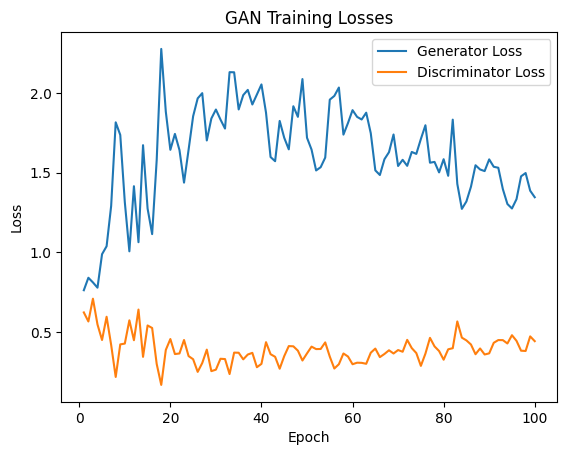

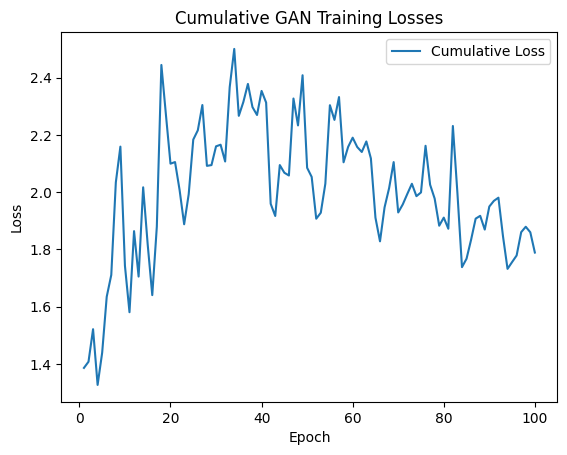

In [8]:
import numpy as np

plt.plot(range(1, epochs+1), gen_losses, label='Generator Loss')
plt.plot(range(1, epochs+1), disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.show()

cumulative_losses = np.array(disc_losses) + np.array(gen_losses)
plt.plot(range(1, epochs+1), cumulative_losses, label='Cumulative Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cumulative GAN Training Losses')
plt.legend()
plt.show()

# GAN Evaluation

## Model Comparision

Now we're created our GAN we need to evaluate it's performance. To do this we are going to train several models on both the real data, the GAN synthetic data, and data generated by a Gaussian Copula. We will then predict on real data with all of these models and visualize the F1 scores of all of these approaches. Firstly we have to create some Gaussian Copula data.

In [9]:
from copulas.multivariate import GaussianMultivariate

dist = GaussianMultivariate()
copulaDfSample = df.sample(n=1000)
dist.fit(copulaDfSample)

# The number of samples our copula and GAN will generate
sampleCount = 1000

copula_data_df = dist.sample(sampleCount)
copula_data_df.income = copula_data_df.income.round()
copula_feature_df = copula_data_df.drop(columns = ['income'])
copula_target_df = copula_data_df['income']

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:5999: Runt

Now we need to appropriately split our original DataFrame to train and test our ML models. We also need to generate a dataset with our GAN generator and convert it into a Pandas DataFrame.

In [15]:
features = df.drop(columns = ['income'])
target = df['income']
# Splitting 80% of our data into training and 20% into testing
from sklearn.model_selection import train_test_split
real_train_feature, real_test_feature, real_train_target, real_test_target = train_test_split(features, target, test_size=0.2, random_state = 0)

# Creating synthetic GAN data
noise = tf.random.normal([sampleCount, noise_dim])
gan_data_feature_TF = generator(noise, training=False)
# Rounding income bracket to 1 or 0
income = gan_data_feature_TF[:, -1]
rounded_income = tf.round(income)
rounded_data = tf.concat([gan_data_feature_TF[:, :-1], tf.expand_dims(rounded_income, axis=1)], axis=1)
# Converting tensors to DataFrames for SKlearn processing
gan_data_df = pd.DataFrame(rounded_data.numpy(), columns=df.columns)
gan_feature_df = gan_data_df.drop(columns = ['income'])
gan_target_df = gan_data_df['income']

print(gan_data_df.head())
print(gan_data_df['income'].nunique())


        age  workclass    fnlwgt  education  education.num  marital.status  \
0  0.495895   0.106401  0.047769   0.843095       0.789030        0.137077   
1  0.863388   0.014321  0.125971   0.917331       0.973638        0.138138   
2  0.221065   0.287074  0.818192   0.674762       0.629695        0.329633   
3  0.283815   0.373748  0.140882   0.727891       0.582692        0.390050   
4  0.557932   0.168656  0.109747   0.826901       0.770516        0.223580   

   occupation  relationship      race           sex  capital.gain  \
0    0.107262      0.980062  0.986730  2.370707e-05      0.003404   
1    0.410611      0.926161  0.932451  5.364233e-13      0.009211   
2    0.236343      0.001598  0.997908  5.689785e-01      0.003933   
3    0.640446      0.959020  0.720385  9.829380e-01      0.059425   
4    0.157152      0.877211  0.955782  7.282627e-05      0.010458   

   capital.loss  hours.per.week  native.country  income  
0      0.005961        0.735485        0.986603     1.0  


Now that we've created our synthetic copula data we will begin creating ML models with scikit-learn to evaluate our F1 scores. First we will implement a Decision Tree Classifier.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

param_grid = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'splitter' : ['best', 'random']
}

# We need to individually optimize hyper parameters for each set of data, first we will handle the real data
# Using GridSearch to find optimal model parameters
dec_tree = DecisionTreeClassifier()
gridSearch = GridSearchCV(dec_tree, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(real_train_feature, real_train_target)
tunedDecTree = gridSearch.best_estimator_

# Model fitting and predicting
tunedDecTree.fit(real_train_feature, real_train_target)
real_prediction = tunedDecTree.predict(real_test_feature)
real_accuracy = accuracy_score(real_test_target, real_prediction)
real_f1 = f1_score(real_test_target, real_prediction)

print(f"Real data trained accuracy: {real_accuracy}")
print(f"Real data trained f1 score: {real_f1}")

# Now we handle GAN data
# Using GridSearch to find optimal model parameters
dec_tree = DecisionTreeClassifier()
gridSearch = GridSearchCV(dec_tree, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(gan_feature_df, gan_target_df)
tunedDecTree = gridSearch.best_estimator_

# Model fitting and predicting
tunedDecTree.fit(gan_feature_df, gan_target_df)
gan_prediction = tunedDecTree.predict(real_test_feature)
gan_accuracy = accuracy_score(real_test_target, gan_prediction)
gan_f1 = f1_score(real_test_target, gan_prediction)

print(f"GAN data trained accuracy: {gan_accuracy}")
print(f"GAN data trained f1 score: {gan_f1}")

# Now we handle Copula data
# Using GridSearch to find optimal model parameters
dec_tree = DecisionTreeClassifier()
gridSearch = GridSearchCV(dec_tree, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(copula_feature_df, copula_target_df)
tunedDecTree = gridSearch.best_estimator_

# Model fitting and predicting
tunedDecTree.fit(copula_feature_df, copula_target_df)
copula_prediction = tunedDecTree.predict(real_test_feature)
copula_accuracy = accuracy_score(real_test_target, copula_prediction)
copula_f1 = f1_score(real_test_target, copula_prediction)

print(f"Copula data trained accuracy: {copula_accuracy}")
print(f"Copula data trained f1 score: {copula_f1}")




Real data trained accuracy: 0.8132964839551666
Real data trained f1 score: 0.6069812540400775
GAN data trained accuracy: 0.48595117457392906
GAN data trained f1 score: 0.3687782805429864
Copula data trained accuracy: 0.5702441271303547
Copula data trained f1 score: 0.35581127733026463


Now we will implement SVC.

In [21]:
from sklearn.svm import SVC

# Parameter grid for SVM
param_grid = {
    'kernel': ['rbf', 'poly'],
}

# First we handle real data
# Using GridSearch to find optimal model parameters
svm = SVC()
gridSearch = GridSearchCV(svm, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(real_train_feature, real_train_target)
tunedSVM = gridSearch.best_estimator_


# Model fitting and predicting
tunedSVM.fit(real_train_feature, real_train_target)
real_prediction = tunedSVM.predict(real_test_feature)
real_accuracy = accuracy_score(real_test_target, real_prediction)
real_f1 = f1_score(real_test_target, real_prediction)

print(f"Real data trained accuracy: {real_accuracy}")
print(f"Real data trained f1 score: {real_f1}")

# Now we handle GAN data
# Using GridSearch to find optimal model parameters
svm = SVC()
gridSearch = GridSearchCV(svm, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(gan_feature_df, gan_target_df)
tunedSVM = gridSearch.best_estimator_

# Model fitting and predicting
tunedSVM.fit(gan_feature_df, gan_target_df)
gan_prediction = tunedDecTree.predict(real_test_feature)
gan_accuracy = accuracy_score(real_test_target, gan_prediction)
gan_f1 = f1_score(real_test_target, gan_prediction)

print(f"GAN data trained accuracy: {gan_accuracy}")
print(f"GAN data trained f1 score: {gan_f1}")


# Now we handle Copula data
# Using GridSearch to find optimal model parameters
svm = SVC()
gridSearch = GridSearchCV(svm, param_grid, cv = 10, n_jobs=-1)
gridSearch.fit(copula_feature_df, copula_target_df)
tunedSVM = gridSearch.best_estimator_

# Model fitting and predicting
tunedSVM.fit(copula_feature_df, copula_target_df)
copula_prediction = tunedDecTree.predict(real_test_feature)
copula_accuracy = accuracy_score(real_test_target, copula_prediction)
copula_f1 = f1_score(real_test_target, copula_prediction)

print(f"Copula data trained accuracy: {copula_accuracy}")
print(f"Copula data trained f1 score: {copula_f1}")


Real data trained accuracy: 0.8478427759864886
Real data trained f1 score: 0.6267419962335217
GAN data trained accuracy: 0.5702441271303547
GAN data trained f1 score: 0.35581127733026463
Copula data trained accuracy: 0.5702441271303547
Copula data trained f1 score: 0.35581127733026463


## Correlation Preservation

In [20]:
from sklearn.feature_selection import mutual_info_regression

mutual_info = []

# Sampling 1000 entries from real data to compare against 1000 synthetic samples
df_sample = df.iloc[:1000]

for realColumn, synthColumn in zip(df_sample.columns, gan_data_df.columns):
  info = mutual_info_regression(df_sample[[realColumn]], gan_data_df[[synthColumn]].values.flatten())
  mutual_info.append(info[0])

print(mutual_info)

[0, 0.017948100782044563, 0, 0, 0.013536812041454738, 0.0034690696750627747, 0, 0, 0.002817537023322325, 0.0647323214316915, 0, 0.0011551433869398942, 0, 0.010831858680188322, 0.029729163405034065]
